# One-vs-Allクラス分類

ロジスティック回帰を用いたOne-vs-Allクラス分類の例として，手書き数字の認識を扱う．

## データのロード

In [2]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec

In [37]:
# 訓練データのロード
data = scipy.io.loadmat('data/ex3data1.mat')
# X_unext: 各ピクセルの画素値（特徴量）からなる行ベクトルを全画像について縦に並べた行列
# y_label: 正解の数字（ターゲット）を全画像について縦に並べた列ベクトル
X_unext, y_label = data['X'], data['y']
y_label[y_label==10] = 0 # 0の画像のラベルが10に書き換えられているため0に戻す
m, n = X_unext.shape
print('訓練データの数（画像の枚数）：m =',m)
print('特徴量の数（ピクセル数）：n =',n)

訓練データの数（画像の枚数）：m = 5000
特徴量の数（ピクセル数）：n = 400


## 仮説とコスト関数の定義

特徴量ベクトルを$x=(x_0 ,x_1 ,\dots ,x_n)^\mathrm{T}$，ターゲットの1-hot表現を$y=(y^0 ,y^1 ,\dots ,y^C)^\mathrm{T}$とする．1-hot表現$y$は$(C+1)$次元ベクトルであり，クラスのラベルが$c$ならば$y$は第$c$成分のみ1で他が0のベクトルとなる．0番目の特徴量は常に$x_0 =1$とする．パラメータ行列$\Theta =(\Theta ^{ic})_{i=0,\dots ,n;c=0,\dots ,C}$に対して仮説を$C$成分ベクトル$h_\Theta (x)=(h_\Theta (x)^0 ,\dots ,h_\Theta (x)^C)^\mathrm{T}$とする．仮説の各成分は次のように与えられる：
$$
h_\Theta (x)^c=\sigma\left(\sum _{i=0}^n x_i \Theta ^{ic} \right) ,\quad\sigma (z)=\frac{1}{1+e^{-z}} .
$$
多クラスのロジスティック回帰では，特徴量$x$が与えられたとき$h_\Theta (x)$の成分が最も大きくなるようなインデックスがターゲットのクラスであると推定する．

コスト関数は交差エントロピーとする：
$$
J(\theta )=-\frac{1}{m} \sum _{d=1}^m \sum _{c=0}^C [y^{(d)c} \log h_\Theta (x^{(d)})^c +(1-y^{(d)c})\log (1-h_\Theta (x^{(d)})^c)].
$$
ただし，$(d)$は$d=1,\dots ,m$番目のデータを表す．このとき，コスト関数の勾配は次のように表される：
$$
\frac{\partial J(\Theta )}{\partial\Theta ^{ic}} =\frac{1}{m} \sum _{d=1}^m (h_\Theta (x^{(d)})^c -y^{(d)c})x_i^{(d)} .
$$

正則化項つきコスト関数は次のように与えられる：
$$
J_\mathrm{r} (\Theta )=J(\Theta)+\frac{1}{2m} \sum _{i=0}^n \sum _{c=0}^C \mu ^i (\Theta ^{ic})^2 .
$$
正則化項に含まれる$\mu =(\mu ^0 ,\mu ^1 ,\dots ,\mu ^n)^\mathrm{T}$はハイパーパラメータである．このとき，コスト関数の勾配は次のように表される：
$$
\frac{\partial J_\mathrm{r} (\Theta )}{\partial\Theta ^{ic}} =\frac{\partial J(\Theta )}{\partial\Theta ^{ic}} +\frac{1}{m} \mu ^i \Theta ^{ic} .
$$
仮説や勾配がクラス$c$ごとに完全に分離しているので，クラスごとにコスト関数を最適化することができる．

In [38]:
# 0番目の特徴量1を追加する関数
# X_unextは追加前のm*n行列，Xは追加後のm*(n+1)行列（特徴量の行ベクトルを縦に並べたもの）
def add1column(X_unext):
    X = np.insert(X_unext,0,1,axis=1)
    return(X)

In [39]:
# 特徴量行列
X = add1column(X_unext)

In [40]:
# ターゲットの1-hot表現
C = 9 # クラス数-1（0から9までの10クラス）
Y = np.zeros((m,C+1))
Y[np.arange(m),y.flatten()] = 1

In [41]:
# シグモイド関数
def sigmoid(z):
    s = 1 / (1 + np.exp(-z))
    return(s)

In [42]:
# コスト関数（正則化項なし）と勾配
def costFunction_gradient(X,y,theta):
    epsilon = 1e-7 # np.log(0) の発散を防ぐ
    m = y.size
    h = sigmoid(X @ theta)
    J = -(1 / m) * np.squeeze((y.T @ np.log(h+epsilon) + (1-y).T @ np.log(1-h+epsilon)))
    J_theta = (1 / m) * X.T @ (h - y)
    return(J,J_theta)

In [43]:
# 正則化項つきコスト関数と勾配
def costFunctionReg_gradient(X,y,theta,mu):
    m = y.size
    J, J_theta = costFunction_gradient(X,y,theta)
    Jr = J + (1 / (2 * m)) * np.squeeze(np.sum(mu * theta**2, axis=0))
    Jr_theta = J_theta + (1 / m) * mu * theta
    return(Jr,Jr_theta)

In [144]:
# 正則化パラメータ
mu1 = 1
mu = mu1 * np.ones((n+1,1))
mu[0] = 0

In [145]:
# 初期パラメータ（ゼロベクトル）
Thetai = np.zeros((n+1,C+1))

## 勾配法

勾配法では，コスト関数の勾配と逆方向にパラメータを動かすことでコスト関数の最小点を探索する．正則化あり勾配法の更新式は次のように与えられる：
$$
\theta\leftarrow\theta -\alpha\frac{\partial J_\mathrm{r} (\theta )}{\partial\theta} .
$$
$\alpha$は学習率と呼ばれる．正則化項は（0番目以外の）特徴量を小さくする効果を持つ．

In [53]:
# 正則化あり勾配法
def gradientDescentReg(X,y,thetai,mu,alpha,num_iters):
    theta = thetai
    Jr_theta = 0
    # theta_history = np.zeros((theta.size,num_iters+1))
    Jr_history = np.zeros((num_iters+1))
    
    for i in np.arange(num_iters+1):
        theta = theta - alpha * Jr_theta
        # theta_history[:,[i]] = theta
        Jr_history[i], Jr_theta = costFunctionReg_gradient(X,y,theta,mu)
    
    return(theta,Jr_history)
    # return(theta,theta_history,Jr_history)

In [202]:
# 正則化あり勾配法によるOne-vs-All分類
def gradientDescentReg_1vsAll(X,Y,Thetai,mu,alpha=0.5,num_iters=3000):
    C = Y.shape[1] - 1
    Theta = Thetai.copy()
    Jr_history = np.zeros((num_iters+1,C+1))
    
    for c in np.arange(C+1):
        Theta[:,[c]], Jr_history[:,c] = gradientDescentReg(X,Y[:,[c]],Thetai[:,[c]],mu,alpha,num_iters)
    
    return(Theta,Jr_history)

正則化パラメータを$\mu =(0,1,\dots ,1)^\mathrm{T}$とし，学習率$\alpha =0.5$，更新回数3,000で勾配法を実行する．

Text(0, 0.5, 'Cost for each class')

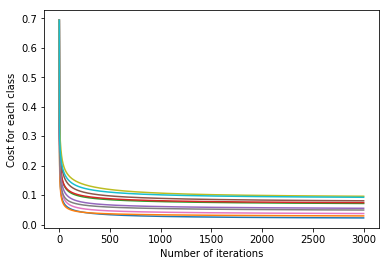

In [203]:
# 正則化あり勾配法の実行
Theta, Jr_history = gradientDescentReg_1vsAll(X,Y,Thetai,mu)

# コストのプロット
plt.plot(Jr_history)
plt.xlabel('Number of iterations')
plt.ylabel('Cost for each class')

勾配法で求めたパラメータから訓練データに対する正解率を計算すると，約93%となる．

In [100]:
# 予測
def predict_1vsAll(X,Theta):
    h = sigmoid(X @ Theta)
    yp_label = np.argmax(h,axis=1).reshape(-1,1)
    return(yp_label)

In [101]:
# 予測と正解率
def predict_accuracy_1vsAll(X,y_label,Theta):
    m = y_label.size
    yp_label = predict_1vsAll(X,Theta)
    I_True = (yp_label == y_label).astype('float')
    acc = np.sum(I_True,axis=0) / m
    return(yp_label,acc)

In [204]:
# 訓練データに対する正解率
_, acc = predict_accuracy_1vsAll(X,y_label,Theta)
print('訓練データに対する正解率',acc[-1])

訓練データに対する正解率 0.9344


## 自然勾配法

次に自然勾配法を実行しよう．正則化したコスト関数$J_\mathrm{r} (\theta )$とFisher情報行列$g_\mathrm{r} (\theta )$の逆行列をかけたものに比例してパラメータを減らしていく：
$$
\theta\leftarrow\theta -\alpha g_\mathrm{r}^{-1} \frac{\partial J_\mathrm{r} (\theta )}{\partial\theta} .
$$
ここで，Fisher情報行列$g(\theta )$の$(i,j)$成分は次のように与えられる：
$$
g_{ij} (\theta )=\frac{1}{m} \sum _{d=1}^m h_\theta (x^{(d)})(1-h_\theta (x^{(d)}))x_i^{(d)} x_j^{(d)} .
$$
また正則化したFisher情報行列$g_\mathrm{r} (\theta )$の$(i,j)$成分は次のように与えられる：
$$
(g_\mathrm{r})_{ij} (\theta )=g_{ij} (\theta )+\frac{1}{m} \mu ^i \delta ^{ij} .
$$
ここで$\delta ^{ij}$はKroneckerのデルタである．

In [177]:
# Fisher情報行列
def FisherMatrix(X,theta):
    m = X.shape[0]
    h = sigmoid(X @ theta)
    h_d1 = h * (1 - h)
    g = (1 / m) * X.T @ (h_d1 * X)
    return(g)

In [178]:
# 正則化項つきFisher情報行列
def FisherMatrixReg(X,theta,mu):
    m = X.shape[0]
    g = FisherMatrix(X,theta)
    gr = g + (1 / m) * np.diag(mu.flatten())
    return(gr)

In [179]:
# 正則化あり自然勾配法
def naturalGradientDescentReg(X,y,thetai,mu,alpha,num_iters):
    theta = thetai
    Jr_theta_n = 0
    # theta_history = np.zeros((theta.size,num_iters+1))
    Jr_history = np.zeros((num_iters+1))
    
    for i in np.arange(num_iters+1):
        theta = theta - alpha * Jr_theta_n
        # theta_history[:,[i]] = theta
        Jr_history[i], Jr_theta = costFunctionReg_gradient(X,y,theta,mu)
        g_inv = np.linalg.inv(FisherMatrixReg(X,theta,mu))
        Jr_theta_n = g_inv @ Jr_theta
    
    return(theta,Jr_history)
    # return(theta,theta_history,Jr_history)

In [189]:
# 正則化あり自然勾配法によるOne-vs-All分類
def naturalGradientDescentReg_1vsAll(X,Y,Thetai,mu,alpha=1,num_iters=10):
    C = Y.shape[1] - 1
    Theta = Thetai.copy()
    Jr_history = np.zeros((num_iters+1,C+1))
    
    for c in np.arange(C+1):
        Theta[:,[c]], Jr_history[:,c] = naturalGradientDescentReg(X,Y[:,[c]],Thetai[:,[c]],mu,alpha,num_iters)
    
    return(Theta,Jr_history)

正則化パラメータを$\mu =(0,1,\dots ,1)^\mathrm{T}$とし，学習率$\alpha =1$で自然勾配法を実行すると，10ステップ程度でコストは収束し，訓練データに対する正解率も約94%となる．

訓練データに対する正解率 0.9446


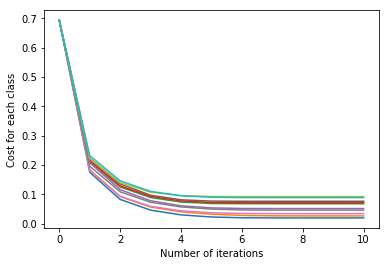

In [205]:
# 正則化あり自然勾配法の実行
Theta, Jr_history = naturalGradientDescentReg_1vsAll(X,Y,Thetai,mu)

# コストのプロット
plt.plot(Jr_history)
plt.xlabel('Number of iterations')
plt.ylabel('Cost for each class')

# 訓練データに対する正解率
_, acc = predict_accuracy_1vsAll(X,y_label,Theta)
print('訓練データに対する正解率',acc[-1])